In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

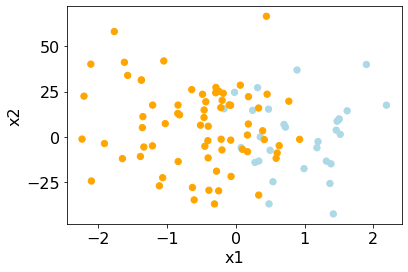

In [2]:
def gen_df(std=False):
    count = 100
    df = pd.DataFrame({"x1": np.random.normal(size=count),
                       "x2": np.random.normal(scale=20, size=count),})
    df["y"] = "orange"
    noise = np.random.normal(size=count, scale=0.5)
    df.loc[df["x1"]>0.5+noise, "y"] = "lightblue"
    return df

train = gen_df()
ax = train.plot.scatter(x="x1", y="x2", c="y", s=40, colorbar=False)

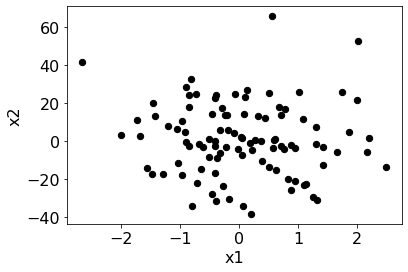

In [3]:
test = gen_df()
ax = test.plot.scatter(x="x1", y="x2", c="k", s=40, colorbar=False)

In [4]:
test.head()

,x1,x2,y
0,-0.716769,-21.909375,orange
1,0.603470,1.051704,lightblue
2,-0.651258,-14.753077,orange
3,-0.911942,4.619872,orange
4,-1.290061,-17.192341,orange


In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import Pipeline

In [6]:
class NearestNeighbor(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.memX_, self.memy_ = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if X.shape[1] != self.memX_.shape[1]:
            raise ValueError("train/test feature mismatch")
        y = []
        for i,row1 in enumerate(X):
            best_dist = None
            for j,row2 in enumerate(self.memX_):
                dist = ((row1 - row2) ** 2).sum() ** 0.5
                if best_dist == None or dist < best_dist:
                    best_dist = dist
                    best_y = self.memy_[j]
            y.append(best_y)
        return np.array(y)

check_estimator(NearestNeighbor)

In [7]:
nn = NearestNeighbor()
nn.fit(train[["x1", "x2"]], train["y"])
test["predict_y"] = nn.predict(test[["x1", "x2"]])
(test["y"] == test["predict_y"]).value_counts()

True     66
False    34
dtype: int64

In [8]:
nn = NearestNeighbor()
nn.fit(train[["x1", "x2"]], train["y"])
nn.score(test[["x1", "x2"]], test["y"])

0.66

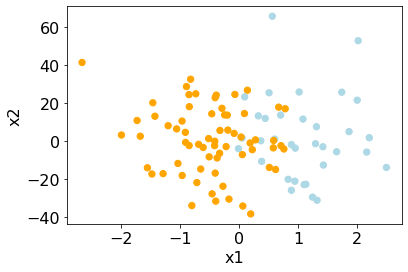

In [9]:
ax = test.plot.scatter(x="x1", y="x2", c="y", s=40, colorbar=False)

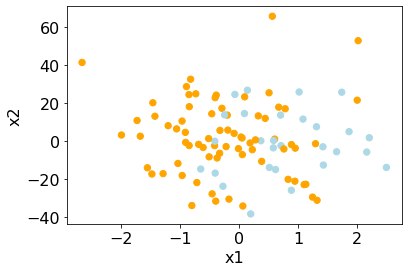

In [10]:
ax = test.plot.scatter(x="x1", y="x2", c="predict_y", s=40, colorbar=False)

In [11]:
class Scaler(TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X = check_array(X)
        self.sdev_ = X.std(axis=0)
        return self
    
    def transform(self, X):
        X = check_array(X)
        return X / self.sdev_

s = Scaler()
#s.fit_transform(train[["x1", "x2"]])
#s.transform(test[["x1", "x2"]])

In [12]:
p = Pipeline([
    ("scaling", Scaler()),
    ("nn", NearestNeighbor()),
])
p.fit(train[["x1", "x2"]], train["y"])
p.score(test[["x1", "x2"]], test["y"])

0.84